In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join
import pickle
import sys
from keras.models import load_model
from keras.utils import to_categorical
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import seaborn as sn

Using TensorFlow backend.


In [2]:
thisPath = os.getcwd()
os.chdir("../../code")
projectDir = os.getcwd()
from evalUtils import plotModelHist, UrgentVRoutne

In [3]:
def reportBinaryScores(yTrueUrgent, yPredProbUrgent, v=0):
    yPredUrgent = yPredProbUrgent.round().astype(np.int)
    tn, fp, fn, tp = confusion_matrix(yTrueUrgent.astype(np.float), 
                                      yPredUrgent).ravel()
    tpr = tp/(tp + fn)
    tnr = tn/(tn + fp)
    fpr = fp/(fp + tn)
    fnr = fn/(fn + tp)
    plr = tpr/fpr #positive likelihood ratio
    nlr = fnr/tnr # negative likelihood ratio
    acc = accuracy_score(yTrueUrgent, 
                         yPredUrgent)
    if v:
        print('\t accuracy: {0:.3g}'.format(acc))
        print("\t sensitivity {0:.3g}".format(tpr))
        print("\t specificity {0:.3g}".format(tnr))
        print("\t positive likelihood ratio {0:.3g}".format(plr))
        print("\t negative likelihood ratio {0:.3g}".format(nlr))
        print("\n")
    return acc, tpr, tnr, plr, nlr

In [4]:
yTestPath = r"D:\Projects\OCT-Image-Classification\PreprocessedData\preprocessedForCNN\224x224\targetData_(224, 224, 3)_test.npy"
yTrueTest = np.load(yTestPath)

In [5]:
modelsPath = r"D:\Projects\OCT-Image-Classification\modelOutput\VGG16Models"
VGGPath1 = r"VGG16_dataAug_False2019-05-19_15_50_3L_asBefore" # what I had before
VGGPath2 = r"VGG16_dataAug_False2019-05-17_1_17_flattenToDense_q" 
VGGPath3 = r"VGG16_dataAug_False2019-05-17_10_55_flattenInsteadofGAP_2L" 
VGGPath4 = r"VGG16_dataAug_False2019-05-24_0_32_default"
#r"VGG16_dataAug_False2019-05-17_14_19_defaultVGG16_4L" 
#VGGPath5 = r"VGG16_dataAug_False2019-05-17_1_4_noGAP_2L" 



0 VGG16_dataAug_False2019-05-19_15_50_3L_asBefore
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)

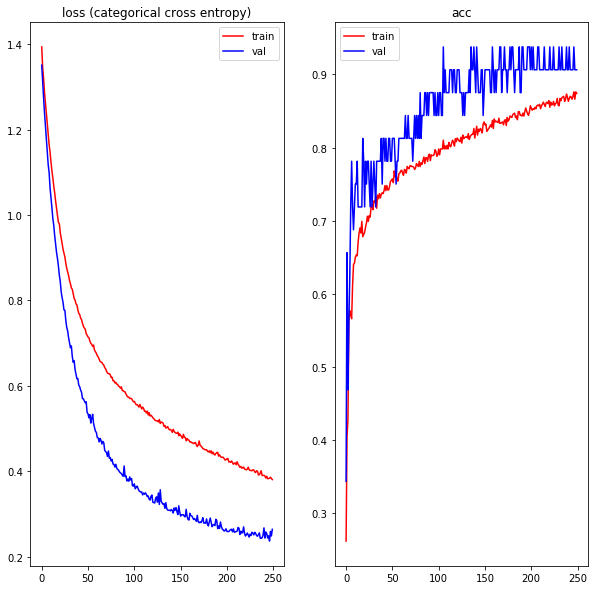

1 VGG16_dataAug_False2019-05-17_1_17_flattenToDense_q
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPoolin

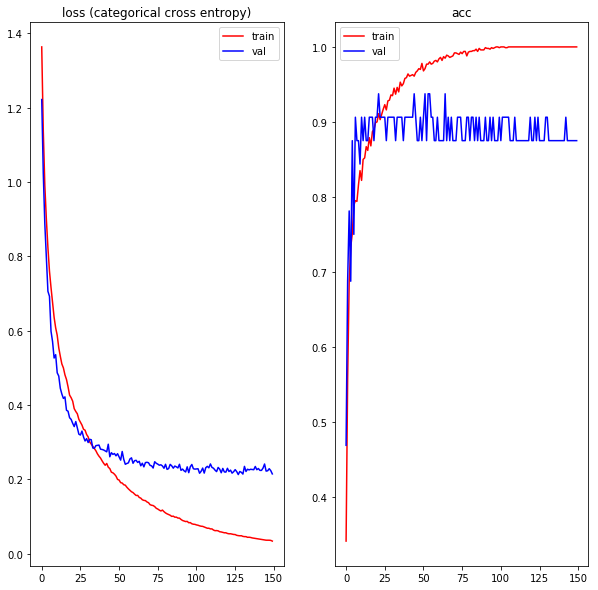

2 VGG16_dataAug_False2019-05-17_10_55_flattenInsteadofGAP_2L
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (Ma

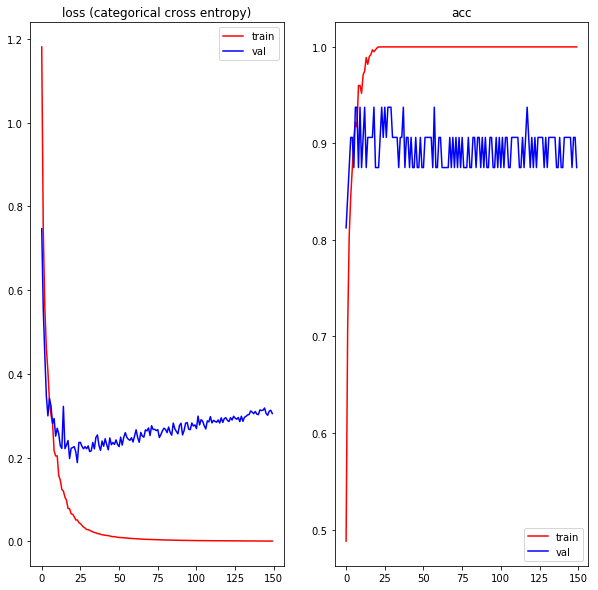

3 VGG16_dataAug_False2019-05-24_0_32_default
cannot load model


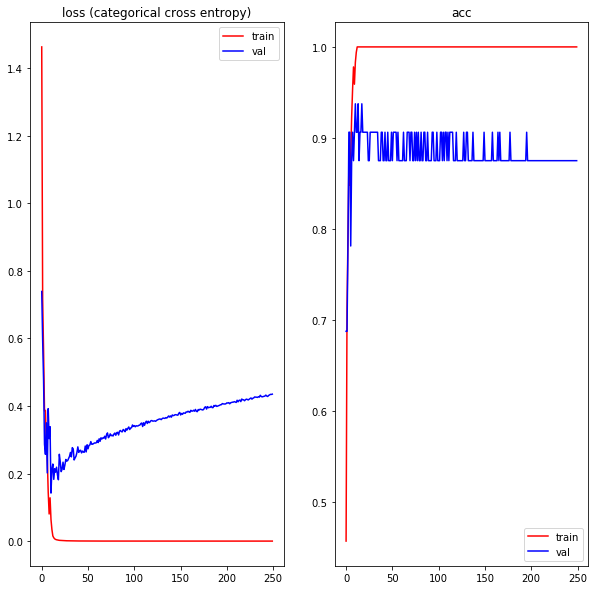

In [6]:
dirList = [VGGPath1, VGGPath2, VGGPath3, VGGPath4]
modelPred = {}
for i, expDir in enumerate(dirList):
    print(i, expDir)
    expPath = join(modelsPath, expDir)
    assert(os.path.isdir(expPath))
    modelPath = join(expPath, "VGG16.hdf5")
    try:
        model = load_model(modelPath)
        model.summary()
    except:
        print('cannot load model')
    
    histPath = join(expPath, "VGG16_History.csv") 
    modelHist = pd.read_csv(histPath, index_col=0)
    plotModelHist(modelHist)
    yTestPred = np.load(join(expPath, "yTestPred.npy"))
    modelPred["VGG16_v{}".format(i)] = yTestPred

In [7]:
classMap = {
    "NORMAL": 0,
    "DRUSEN": 1,
    "CNV": 2,
    "DME": 3}


yTrue1Hot = to_categorical(yTrueTest)
yTrueTestUrgent = UrgentVRoutne(yTrue1Hot, classMap).astype(np.int)


In [8]:
AccListVGG16 = []
SensListVGG16 = []
SpecListVGG16 = []

aucListVGG16 = []
fprsListVGG16 = []
tprsListVGG16 = []

metricDict = {}

for vgg_i in modelPred.keys():
    print(vgg_i)
    yTestPred = modelPred[vgg_i]
    yTestPredUrgent = UrgentVRoutne(yTestPred, classMap)
    
    
    scores = reportBinaryScores(yTrueTestUrgent, yTestPredUrgent, v=1)
    acc, tpr, tnr, plr, nlr = scores
    
    fprs, tprs, _ = roc_curve(yTrueTestUrgent, yTestPredUrgent)
    aucUrgent = auc(fprs, tprs)
    
    metricDict[vgg_i] = {}
    metricDict[vgg_i]["acc"] = acc
    metricDict[vgg_i]["tpr"] = tpr
    metricDict[vgg_i]["tnr"] = tnr
    metricDict[vgg_i]["aucUrgent"] = aucUrgent
    metricDict[vgg_i]["fprs"] = fprs
    metricDict[vgg_i]["tprs"] = tprs
    
    AccListVGG16.append(acc)
    SensListVGG16.append(tpr)
    SpecListVGG16.append(tnr)
    
    aucListVGG16.append(aucUrgent)
    fprsListVGG16.append(fprs)
    tprsListVGG16.append(tprs)

VGG16_v0
	 accuracy: 0.921
	 sensitivity 0.893
	 specificity 0.95
	 positive likelihood ratio 18
	 negative likelihood ratio 0.113


VGG16_v1
	 accuracy: 0.92
	 sensitivity 0.942
	 specificity 0.899
	 positive likelihood ratio 9.31
	 negative likelihood ratio 0.0644


VGG16_v2
	 accuracy: 0.925
	 sensitivity 0.928
	 specificity 0.921
	 positive likelihood ratio 11.8
	 negative likelihood ratio 0.0785


VGG16_v3
	 accuracy: 0.925
	 sensitivity 0.932
	 specificity 0.917
	 positive likelihood ratio 11.3
	 negative likelihood ratio 0.0743




In [9]:
metricsDF = pd.DataFrame(index=modelPred.keys(), columns=['acc', 'tpr', 'tnr', 'auc'])
metricsDF["acc"] = AccListVGG16
metricsDF["tpr"] = SensListVGG16
metricsDF["tnr"] = SpecListVGG16
metricsDF["auc"] = aucListVGG16


In [10]:
metricsDF

,acc,tpr,tnr,auc
VGG16_v0,0.921488,0.892562,0.950413,0.972884
VGG16_v1,0.920455,0.942149,0.898760,0.974088
VGG16_v2,0.924587,0.927686,0.921488,0.973269
VGG16_v3,0.924587,0.931818,0.917355,0.975085


In [11]:
reportedAcc = 0.934
reportedSens = 0.966
reportedSpec = 0.94
reportedAuc = 0.988

reportedMetrics = [reportedAcc, 
                   reportedSens, 
                   reportedSpec,
                   reportedAuc]

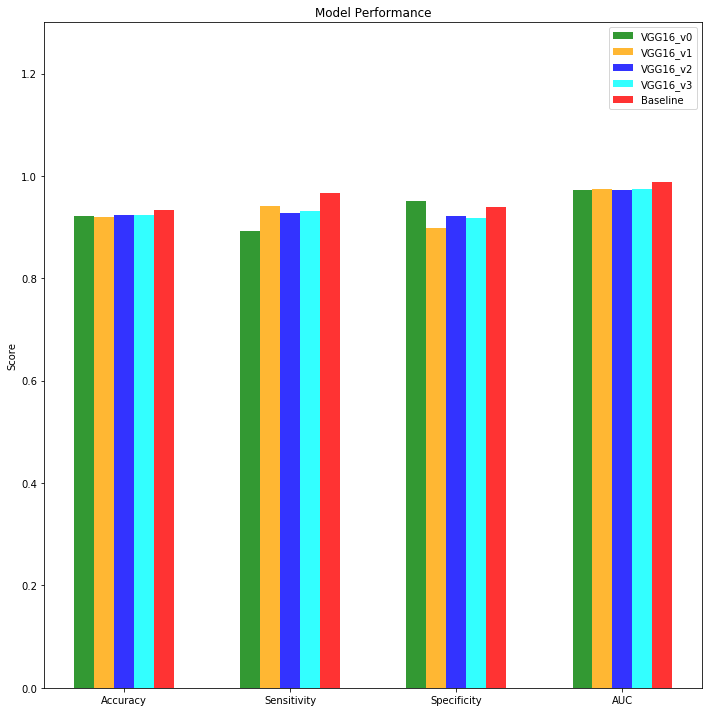

In [12]:
opacity = 0.8
error_config = {'ecolor': '0.3'}
n_groups = 4
nModels = len(modelPred.keys()) + 1

fig, ax = plt.subplots(figsize=(10, 10))
index = np.arange(n_groups)
bar_width = 0.12
colors = ['green', 'orange', 'blue', 'cyan']
for i, (vgg_i, c) in enumerate(zip(modelPred.keys(), colors)):
    
    xpos = index - nModels*bar_width/2 + (i+1)*bar_width
    rectsi = ax.bar(xpos, 
                    metricsDF.loc[vgg_i], bar_width,
                    alpha=opacity, color=c,
                    label=vgg_i)

xpos = index - nModels*bar_width/2 + (i+2)*bar_width
rects2 = ax.bar(xpos, reportedMetrics, bar_width,
                alpha=opacity, color='r', 
                label='Baseline')

#ax.set_xlabel('Group')
ax.set_ylabel('Score')
ax.set_title('Model Performance')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Accuracy', 'Sensitivity', 'Specificity', 'AUC'))
ax.set_ylim([0.0, 1.3])
ax.legend()

fig.tight_layout()
plt.show()
    